# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice. Zkusíme si ho například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint
import random

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Abychom mohli řešení vyhodnocovat, budeme také potřebovat fitness funkci, což bude hodnota rastrigin funkce v daném bodě.

In [4]:
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic a na aktualizaci akuální nejlepší pozice. Také bude potřeba funkce na update nejlepšího globálního řešení.

In [5]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*random.uniform(0, 1)*(particle.best_position - particle.position) + phi2*random.uniform(0, 1)*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat.

   0: 3.7888
   1: 2.1440
   2: 2.0836
   3: 2.0218
   4: 2.0072
   5: 2.0072
   6: 1.9974
   7: 1.9974
   8: 1.9960
   9: 1.9953
  10: 1.9912
  11: 1.9912
  12: 1.9902
  13: 1.9902
  14: 1.9900
  15: 1.9900
  16: 1.9900
  17: 1.9900
  18: 1.9900
  19: 1.9900
  20: 1.9900
  21: 1.9900
  22: 1.9900
  23: 1.9900
  24: 1.9900
  25: 1.9900
  26: 1.9900
  27: 1.9900
  28: 1.9900
  29: 1.9900
best position
[[2.23331595e-04 9.94595937e-01 9.95119429e-01 2.33885817e-05]]


Text(0.5, 0, 'Generace')

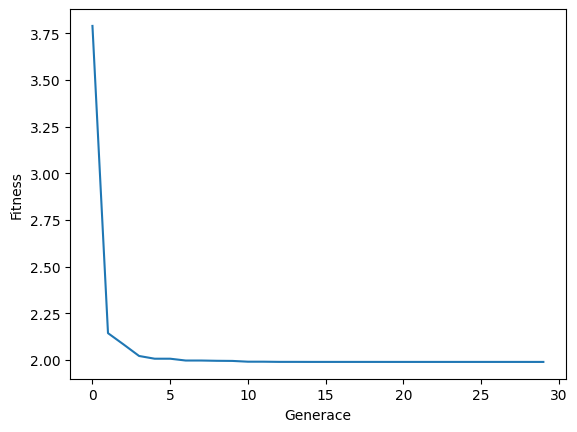

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=3000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Do této struktury si načteme vstupní data ze souboru *cities.csv*, který obsahuje hlavní evropská města s jejich souřadnicemi.

In [9]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [10]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [11]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [12]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce ```generate_solutions```, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. K tomu se bude hodit funkce ```compute_prob```, která počítá pravděpodobnost výběru následujícího vrcholu. 

In [13]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution

Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [14]:
def ant_solver(vertices, distance, ants=10, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

A zkusíme si algoritmus otestovat.

In [15]:
best_solution, pheromones = ant_solver(vertices, distance)
print('Min distance, Mean distance, Max distance')

   0, 349.7313, 391.2623, 450.2089
   1, 299.9736, 336.5234, 383.3380
   2, 295.8978, 332.7063, 381.2827
   3, 288.5262, 314.7198, 355.1255
   4, 260.3689, 303.5974, 341.1540
   5, 285.9677, 316.3308, 335.6543
   6, 283.7612, 307.2600, 335.8319
   7, 261.8446, 296.6409, 330.0058
   8, 264.3860, 301.8166, 345.7458
   9, 277.9190, 298.2149, 320.7998
  10, 273.2756, 296.4132, 336.2302
  11, 265.9523, 304.8057, 322.9616
  12, 258.2723, 304.8795, 346.6224
  13, 264.5197, 298.2510, 347.3593
  14, 269.8042, 308.1263, 338.2427
  15, 268.8394, 304.3113, 347.2981
  16, 262.4227, 296.9261, 332.8958
  17, 258.9989, 289.0749, 330.5081
  18, 276.8559, 300.7454, 343.2307
  19, 265.4017, 307.1356, 362.0113
  20, 263.2073, 299.4121, 323.6220
  21, 269.4739, 301.6057, 334.7292
  22, 267.4036, 304.5058, 327.7128
  23, 261.7745, 299.5034, 352.0157
  24, 259.5016, 305.2529, 341.2761
  25, 279.5600, 307.9093, 333.2909
  26, 259.5016, 305.9184, 360.8793
  27, 259.0377, 296.9056, 335.0021
  28, 255.6654, 291.

 238, 280.9614, 314.6599, 354.9846
 239, 293.0812, 320.4558, 355.5519
 240, 289.4209, 331.9355, 398.3383
 241, 283.7066, 309.6438, 354.9808
 242, 305.9987, 324.2158, 348.4904
 243, 275.2357, 312.2659, 357.9184
 244, 275.2357, 308.2173, 357.4899
 245, 289.7042, 315.6088, 364.3155
 246, 291.7949, 317.6121, 342.3742
 247, 289.1943, 313.4351, 342.0184
 248, 274.4964, 311.3056, 345.0164
 249, 277.3314, 313.6464, 356.1047
 250, 286.4548, 318.6710, 366.0258
 251, 282.0724, 322.0472, 378.7491
 252, 264.7936, 309.5231, 341.7635
 253, 289.4277, 316.6563, 364.0641
 254, 292.4234, 315.4392, 345.1763
 255, 283.1498, 305.1077, 333.0448
 256, 281.4973, 326.2559, 368.6229
 257, 283.7066, 304.5222, 365.3113
 258, 289.7508, 310.3587, 331.9346
 259, 288.1122, 310.6629, 345.9057
 260, 276.2845, 307.4991, 344.7626
 261, 295.5111, 309.0530, 342.7789
 262, 275.8533, 306.1750, 340.0444
 263, 288.5884, 309.2543, 323.7577
 264, 276.2845, 313.9340, 408.4921
 265, 283.3884, 301.6259, 318.8906
 266, 281.2633, 291.

 477, 268.9314, 295.7903, 315.4484
 478, 271.0269, 298.1926, 336.9175
 479, 267.7086, 292.9820, 349.4839
 480, 273.8444, 293.7249, 317.4881
 481, 269.2939, 295.5972, 354.7166
 482, 269.2939, 295.5900, 323.4070
 483, 263.9430, 308.5112, 359.5496
 484, 249.3635, 294.8370, 330.6102
 485, 260.8939, 293.6670, 334.9665
 486, 267.5693, 300.4366, 337.7095
 487, 267.4803, 300.5162, 338.3052
 488, 244.9029, 286.5497, 334.5113
 489, 273.2622, 295.1826, 338.5190
 490, 273.7658, 305.3849, 345.0437
 491, 267.4803, 311.9234, 353.8824
 492, 271.4722, 299.3826, 314.0505
 493, 291.0984, 313.2392, 348.4960
 494, 267.4803, 299.3473, 337.5328
 495, 295.0795, 323.5861, 350.0439
 496, 267.4803, 303.7400, 342.4680
 497, 243.6834, 300.5780, 352.7445
 498, 275.1573, 304.1740, 334.1617
 499, 267.4803, 297.2111, 319.0460
 500, 267.4803, 292.2659, 321.2213
 501, 267.4803, 301.0045, 321.8994
 502, 267.4803, 291.8118, 317.9320
 503, 281.2693, 305.8425, 335.1081
 504, 267.4803, 296.3517, 327.8293
 505, 273.8891, 296.

 716, 276.7352, 300.0288, 334.4472
 717, 278.9043, 300.4361, 325.6842
 718, 275.5368, 297.1818, 332.6127
 719, 278.5372, 297.5357, 335.6259
 720, 276.2482, 295.0453, 341.0916
 721, 282.7665, 304.7030, 334.6004
 722, 269.9592, 291.7915, 308.0845
 723, 274.2775, 292.5719, 312.8572
 724, 275.9302, 297.7428, 321.5584
 725, 266.5275, 293.5567, 314.0308
 726, 289.1884, 302.4627, 337.0668
 727, 279.2686, 295.8845, 308.2454
 728, 287.8275, 321.0921, 359.1826
 729, 267.3306, 314.5732, 348.8874
 730, 279.3166, 315.6983, 364.8011
 731, 281.5280, 298.4891, 341.4243
 732, 273.8638, 298.1618, 334.0293
 733, 281.9112, 304.1245, 339.2060
 734, 278.5955, 296.1379, 337.4357
 735, 273.5491, 289.1927, 301.0352
 736, 270.5029, 294.3591, 322.2315
 737, 281.3595, 296.1655, 327.1171
 738, 267.8970, 287.0879, 305.6647
 739, 278.0010, 290.4018, 316.3524
 740, 270.7859, 293.6171, 327.1079
 741, 248.6583, 289.9479, 323.2561
 742, 268.1536, 291.7432, 316.9896
 743, 271.8085, 288.7190, 342.7016
 744, 275.0098, 281.

 959, 258.8118, 278.6647, 308.9536
 960, 259.9802, 268.8300, 281.3863
 961, 266.5300, 277.5366, 306.6578
 962, 254.7861, 276.0088, 321.1769
 963, 259.9822, 279.5504, 303.4364
 964, 255.8701, 268.9948, 298.1304
 965, 255.8701, 284.8292, 306.6510
 966, 245.4422, 267.8639, 292.7936
 967, 245.4422, 278.0212, 299.6043
 968, 259.7662, 278.0144, 303.3164
 969, 266.5300, 283.7113, 301.2593
 970, 259.4054, 282.9861, 307.4523
 971, 262.0029, 278.9591, 296.9764
 972, 263.6132, 300.6113, 364.3704
 973, 254.3757, 285.2278, 336.9063
 974, 267.1387, 283.1274, 340.0516
 975, 255.8113, 273.7285, 305.6929
 976, 262.0029, 278.8772, 300.7955
 977, 259.1061, 277.6255, 300.3452
 978, 255.8113, 278.2452, 334.0911
 979, 262.0029, 280.4245, 311.1295
 980, 257.1328, 285.4304, 307.1643
 981, 269.7607, 287.0446, 307.1324
 982, 259.4852, 284.9096, 327.2768
 983, 270.9566, 286.6139, 318.4411
 984, 271.5152, 290.5433, 318.7964
 985, 254.3229, 288.0330, 322.8478
 986, 273.2268, 289.0483, 307.5524
 987, 247.6259, 291.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  233.84885223918198
[Vertex(name='Oslo', x=10.75, y=59.9),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Bratislava', x=17.11666667, y=48.15),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Valletta', x=14.51666667, y=35.9),
 Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Podgorica', x=19.26666667, y=42.46666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Belgrade', x=20.5, y=44.81666667),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Skopje', x=21.46666667, y=42.0),
 Vertex(name='Pris

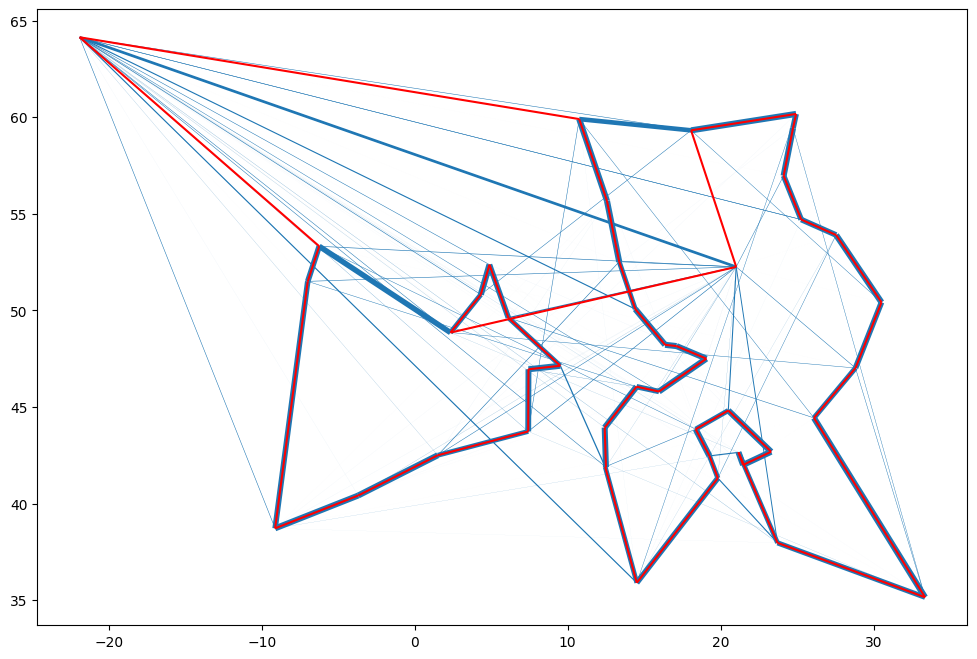

In [16]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy. Při nalezení nového zdroje se z nich zase stávají dělnice.

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic. Pro inspiraci je vyřešený například [zde](https://github.com/rwuilbercq/Hive).

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).